In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#hardware
device = 'cuda:0'

from circuit_explorer.utils import load_config, convert_relu_layers


config = load_config('../configs/alexnet_sparse_config.py')
model = config.model.to('cpu')
convert_relu_layers(model)


#### quick launch
To get a quick sense for the circuit diagramming tools interactivity, run the lines below. The resultant plot is interactive, click a vertex or edge to isolate, click anywhere else in the graph to unisolate

In [ ]:
import torch
from circuit_explorer.visualizer_2d_circuit.circuit_gui import *

viz_folder = '../visualization_cache/circuit_features10:56/'
circuit_dict = torch.load(viz_folder+'circuit_diagram.pt')
circuit = circuit_dict['model']
dfs = circuit_dict['dfs']
port=8050    #if you are running locally, you may have to setup port forwarding https://ljvmiranda921.github.io/notebook/2018/01/31/running-a-jupyter-notebook/
circuit_diagram = launch_circuit_gui(circuit,None,model,None,dfs=dfs,viz_folder=viz_folder,interactive=True,port=port,device=device,inline=True)


In [ ]:
from circuit_explorer.visualizer_2d_circuit.circuit_gui import *

viz_folder = './visualization_cache/demo_diagram/'
port=8050
circuit_diagram = launch_circuit_gui(circuit,None,model,None,dfs=dfs,viz_folder=viz_folder,interactive=True,port=port,device=device)

#### From Scratch

In [3]:
#feature target

layer = 'features_6'
unit = 56


In [4]:
#dataloader
from circuit_explorer.data_loading import rank_image_data
from circuit_explorer.data_loading import single_image_data
from torch.utils.data import DataLoader


#make 'general' filter dataloader
imnet_kwargs = {'num_workers': 4, 'pin_memory': True, 'sampler':None} if 'cuda' in device else {}

#(this data loader is of 2 random images from each imagenet class)
imnet2_dataloader = DataLoader(rank_image_data(config.data_path,
                                               class_folders=True),
                               batch_size=5,
                               shuffle=False,
                               **imnet_kwargs)


In [ ]:
#setup model
import torch
import os
import sys
sys.path.append(os.path.abspath('../circuit_explorer/visualizer_2d_circuit/')) # this tool uses an older version of API
from copy import deepcopy

from circuit_pruner.force import setup_net_for_circuit_prune, show_model_layer_names
from circuit_pruner.dissected_Conv2d import dissect_model, set_across_model, set_model_target_node


#we need to 'dissect' the model, which allows us to access kernel-wise activation maps
kernel_rankable_model = dissect_model(deepcopy(model), dissect=True,store_ranks = True, device=device)
kernel_rankable_model.to(device)


set_model_target_node(kernel_rankable_model,layer,unit)
set_across_model(kernel_rankable_model,'rank_field','image')
set_across_model(kernel_rankable_model,'absolute_rank',True)

In [6]:
#actually extract ranks by running images through model

from circuit_pruner.dissected_Conv2d import get_ranklist_from_dissected_Conv2d_modules, clear_ranks_across_model



clear_ranks_across_model(kernel_rankable_model)

iter_dataloader = iter(imnet2_dataloader)
iters = len(iter_dataloader)

for it in range(iters):

    inputs, label = next(iter_dataloader)
    inputs = inputs.to(device)
    

    kernel_rankable_model.zero_grad()

    try:
        outputs = kernel_rankable_model(inputs)
    except:
        pass

ranks = get_ranklist_from_dissected_Conv2d_modules(kernel_rankable_model, structure='kernels')

In [7]:
#extract model (large circuit)

from circuit_pruner.extraction import model_ranks_2_circuit_model

sparsity = .9

feature_targets = {layer:[unit]}
kernel_pruned_circuit,kernel_mask = model_ranks_2_circuit_model(ranks,sparsity,
                                                           model,feature_targets,device,
                                                           structure='kernels',use_effective_mask=True,
                                                           rank_field='image')


features_6 effective last layer
target sparsity: 0.9
total params to feature: 12672

kept params in original mask: 11405      (total params * sparsity)
original mask: 300460 params
effective mask: 300460 params
effective_sparsity: 0.8999368686868687


------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:13<00:00, 37.19it/s]



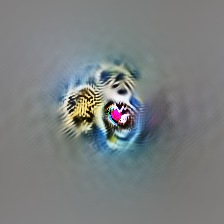

(13, 13)
(6, 6)
[(62.0, 161.0), (62.0, 161.0)]


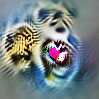

In [8]:
#visualize large circuit (original feature)

#from circuit_pruner.visualizer.featureviz  import featviz_in_recep_field
from featureviz  import featviz_in_recep_field

featviz_in_recep_field(kernel_pruned_circuit,layer,0,margin=0)

In [9]:
#extract model (small circuit)

from circuit_pruner.extraction import model_ranks_2_circuit_model


sparsity = .007

kernel_pruned_circuit,kernel_mask = model_ranks_2_circuit_model(ranks,sparsity,
                                                           model,feature_targets,device,
                                                           structure='kernels',use_effective_mask=True,
                                                           rank_field='image')


features_6 effective last layer
target sparsity: 0.007
total params to feature: 12672

kept params in original mask: 89      (total params * sparsity)
original mask: 2920 params
effective mask: 1818 params
effective_sparsity: 0.002051767676767677


------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:05<00:00, 86.21it/s]



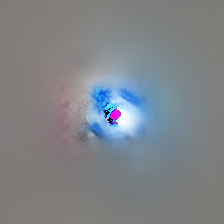

(13, 13)
(6, 6)
[(62.0, 161.0), (62.0, 161.0)]


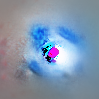

In [10]:
featviz_in_recep_field(kernel_pruned_circuit,layer,0,margin=0)

In [11]:
kernel_pruned_circuit

Sequential(
  (features_0): Conv2d(3, 5, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (features_1): ReLU()
  (features_2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (features_3): Conv2d(5, 5, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (features_4): ReLU()
  (features_5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (features_6): Conv2d(5, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [ ]:
#reload original model

from torchvision import models
import torch.nn as nn
from circuit_explorer import root_path


model = models.alexnet(pretrained=True)

model_statedict = torch.load(root_path+'/models/alexnet_sparse_statedict.pt',map_location='cpu')
model.load_state_dict(model_statedict)


In [13]:
#from circuit_pruner.visualizer.utils import *
from circuit_explorer.visualizer_2d_circuit.utils import *

edge_df = gen_circuit_model_mapping_df(model,kernel_mask,ranks,version = 'edges')
node_df = gen_circuit_model_mapping_df(model,kernel_mask,ranks,version = 'nodes')

dfs = [edge_df,node_df]

already kernel ranks . . .


In [ ]:
#launch gui
#from circuit_pruner.visualizer.circuit_gui import *
from circuit_gui import *
port=8050

circuit_diagram = launch_circuit_gui(kernel_pruned_circuit,None,model,None,
                                     dfs=dfs,interactive=False,port=port,device=device)


In [ ]:
circuit_diagram[0].show()

In [17]:
circuit_dict = {'model':kernel_pruned_circuit,
                'dfs':dfs}

torch.save(circuit_dict,'../visualization_cache/circuit_features10:56/circuit_diagram.pt')